# 제목

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

## #02. 데이터셋 준비하기

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


03. 데이터 전처리 
결측치확인

04. 탐색적 데이터 분석
기본통계 확인


In [3]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

c:\Users\MegaIT302-02\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

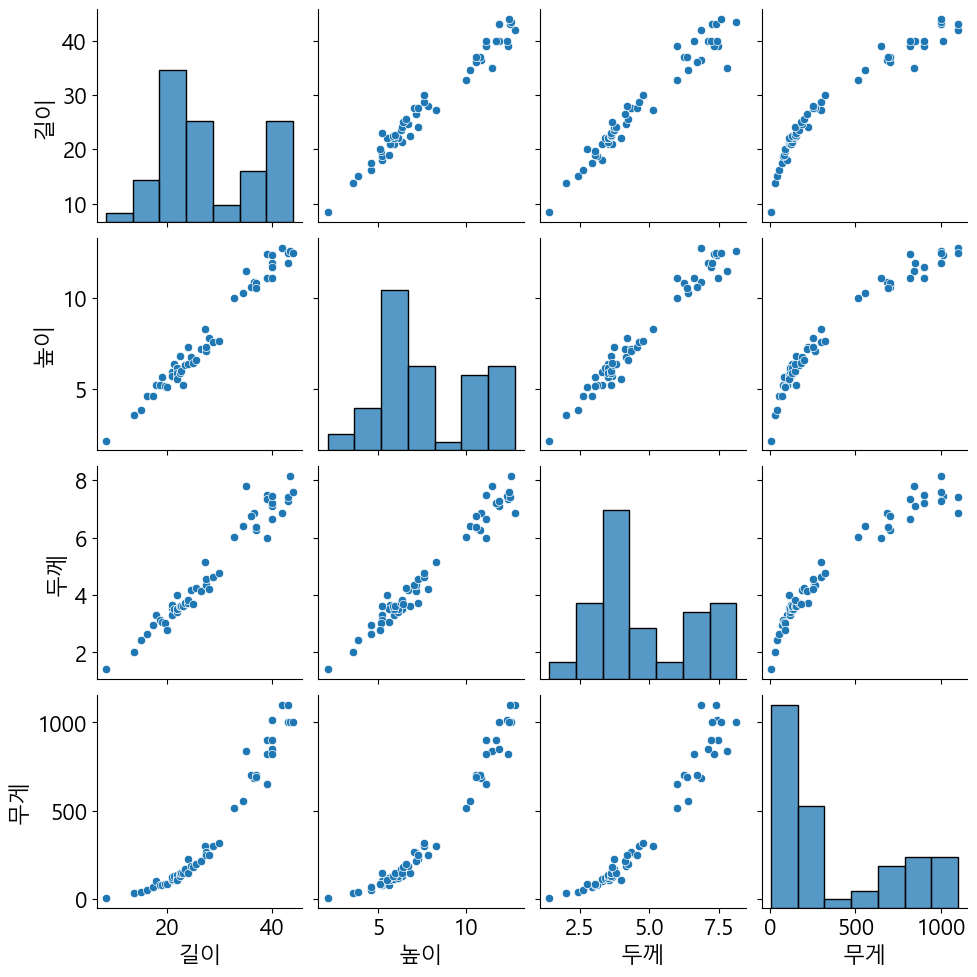

In [4]:
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

> 산점도 그래프의 형태로 보아 다항식이 적합해 보임

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [5]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [6]:
x = origin[['길이','높이','두께']]
y = origin[['무게']]
x.shape, y.shape

((56, 3), (56, 1))

#### 표준화를 하고 다항식으로 바꿔야 한다. 


### 데이터 표준화

In [7]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)

y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape , y_scale.shape

((56, 3), (56, 1))

In [8]:
x_scale_df = DataFrame(x_scale, columns=['길이','높이','두께'])
x_scale_df.head()

,길이,높이,두께
0,-2.180225,-2.016507,-1.896175
1,-1.587434,-1.518703,-1.560774
2,-1.442032,-1.417039,-1.316328
3,-1.307815,-1.147103,-1.202633
4,-1.173599,-1.147103,-1.026405


### 독립변수를 다항식으로 변환

In [9]:
poly = PolynomialFeatures(degree=2, include_bias=False)
fit = poly.fit_transform(x_scale_df)
x2 = DataFrame(fit, columns=poly.get_feature_names_out())
x2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479
1,-1.587434,-1.518703,-1.560774,2.519946,2.410841,2.477625,2.306460,2.370352,2.436014
2,-1.442032,-1.417039,-1.316328,2.079457,2.043416,1.898188,2.008000,1.865289,1.732721
3,-1.307815,-1.147103,-1.202633,1.710381,1.500199,1.572822,1.315845,1.379544,1.446326
4,-1.173599,-1.147103,-1.026405,1.377334,1.346238,1.204588,1.315845,1.177393,1.053508


### 훈련 데이터와 검증 데이터로 분할

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x2, y_scale, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 9), (17, 9), (39, 1), (17, 1))

## #06. 모델 개발

### 모델 정의

In [11]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train.iloc[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [12]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
2/2 [==============================] - 1s 154ms/step - loss: 1.6550 - mae: 1.1035 - val_loss: 0.9797 - val_mae: 0.8773 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 22ms/step - loss: 1.3000 - mae: 1.0005 - val_loss: 0.7693 - val_mae: 0.7927 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 27ms/step - loss: 1.0404 - mae: 0.9058 - val_loss: 0.5979 - val_mae: 0.7100 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 27ms/step - loss: 0.8210 - mae: 0.8151 - val_loss: 0.4612 - val_mae: 0.6280 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 26ms/step - loss: 0.6629 - mae: 0.7315 - val_loss: 0.3537 - val_mae: 0.5458 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 24ms/step - loss: 0.5269 - mae: 0.6409 - val_loss: 0.2724 - val_mae: 0.4684 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 0.4122 - mae: 0.5584 - val_loss: 0.2083 - val_mae: 0.3956 - lr: 0.001

## #07. 학습 결과 평가

In [13]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,1.655038,1.103489,0.979740,0.877318,0.001
2,1.299997,1.000498,0.769327,0.792741,0.001
3,1.040352,0.905784,0.597860,0.709959,0.001
4,0.820983,0.815119,0.461212,0.628036,0.001
5,0.662851,0.731535,0.353694,0.545798,0.001
6,0.526875,0.640917,0.272411,0.468373,0.001
7,0.412246,0.558434,0.208265,0.395597,0.001
8,0.318297,0.479866,0.154051,0.342018,0.001
9,0.239062,0.409515,0.111160,0.295902,0.001


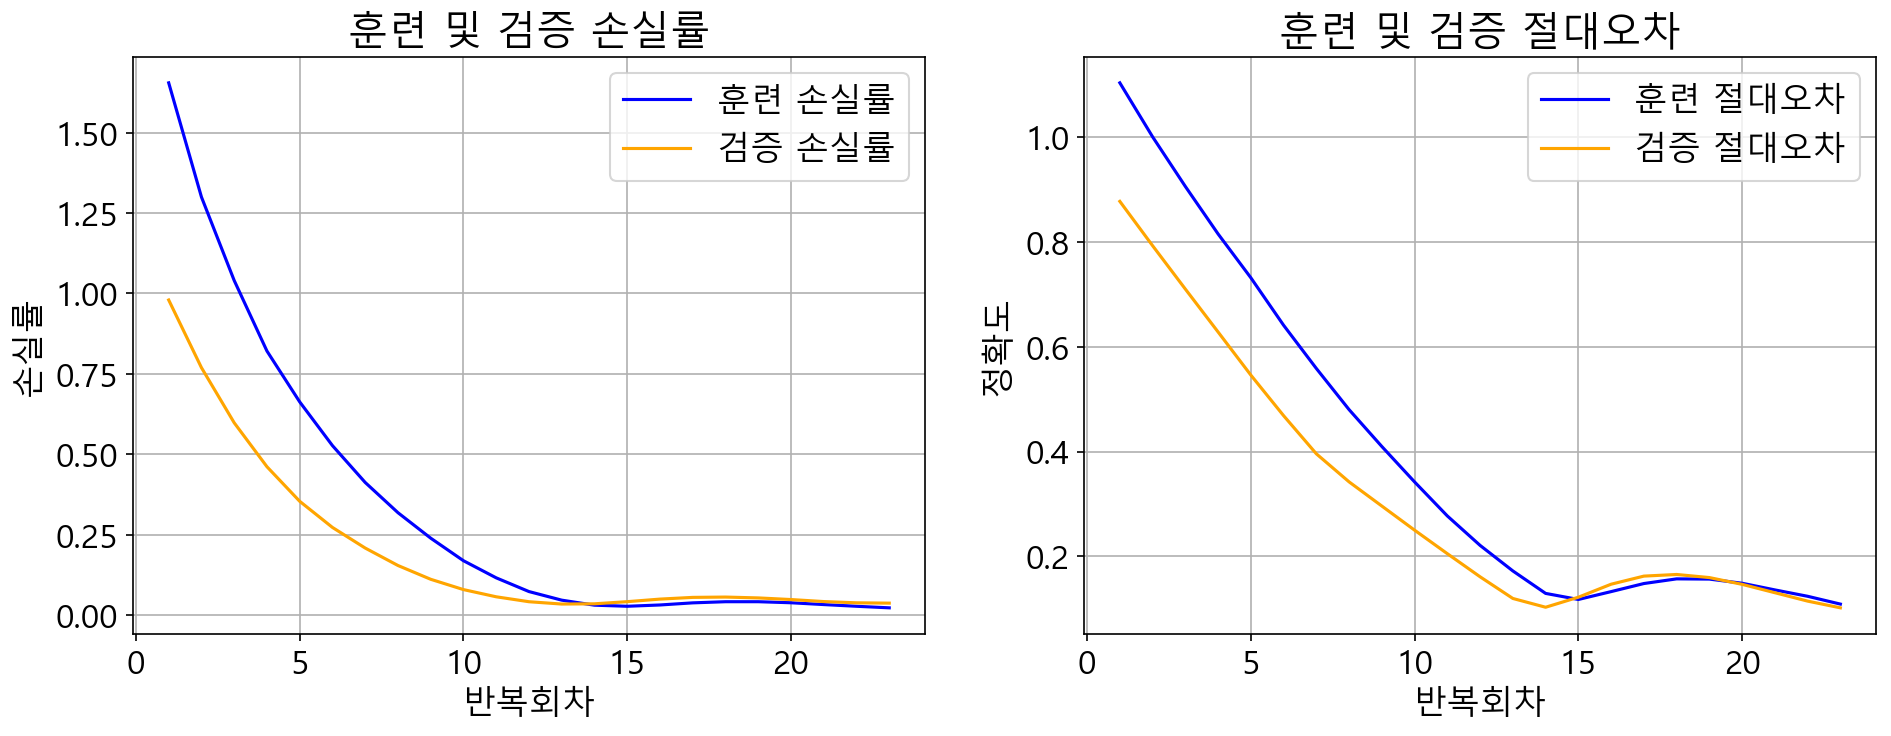

In [14]:
# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [15]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 3ms/step - loss: 0.0205 - mae: 0.1010
최종 훈련 손실률: 0.020515, 최종 훈련 절대오차: 0.101016
1/1 [==============================] - 0s 20ms/step - loss: 0.0370 - mae: 0.1017
최종 검증 손실률: 0.036997, 최종 검증 절대오차: 0.101691


## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [16]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


### 결과 데이터 셋 구성

In [1]:
#train_df['무게(관측치)'] = y_train.iloc[0]
'''
데이터프레임은 칼럼을 선택할 때 []를 사용하고, 행을 선택할때는 loc[] 또는 iloc[]를 사용한다. 
loc[] 인덱스 명으로 행 접근
iloc[] 0부터 시작하는 정수형 인덱스로 행 접근(설정된 인덱스명과 상관없다) 
- 쉼표를 사용해서 여러개의 칼럼 선택 가능
- 행과 열을 동시에 선택 가능
행 추출 결과 : 행 1개만 추출할 때는 해당 행을 시리즈 형태로 추출 
/ 여러개의 행을 동시에 추출할 때는 리스트 형태로 추출 
'''

'\n데이터프레임은 칼럼을 선택할 때 []를 사용하고, 행을 선택할때는 loc[] 또는 iloc[]를 사용한다. \nloc[] 인덱스 명으로 행 접근\niloc[] 0부터 시작하는 정수형 인덱스로 행 접근(설정된 인덱스명과 상관없다) \n- 쉼표를 사용해서 여러개의 칼럼 선택 가능\n- 행과 열을 동시에 선택 가능\n행 추출 결과 : 행 1개만 추출할 때는 해당 행을 시리즈 형태로 추출 \n/ 여러개의 행을 동시에 추출할 때는 리스트 형태로 추출 \n'

In [17]:
train_df = DataFrame(x_train, columns=x2.columns)
train_df['무게(관측치)'] = y_train.flatten()
#train_df['무게(관측치)'] = y_train.iloc[0]
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
8,-0.927534,-0.954292,-0.969558,0.860320,0.885138,0.899298,0.910672,0.925241,0.940042,-0.862814,-0.964729,0.101915
0,-2.180225,-2.016507,-1.896175,4.753381,4.396440,4.134088,4.066302,3.823651,3.595479,-1.092422,-0.933742,-0.158680
15,-0.659101,-0.779008,-0.696689,0.434414,0.513445,0.459188,0.606854,0.542726,0.485375,-0.761217,-0.789771,0.028554
26,-0.368297,-0.396891,-0.327179,0.135643,0.146174,0.120499,0.157523,0.129854,0.107046,-0.563830,-0.503907,-0.059922
51,1.577847,1.731046,1.207709,2.489601,2.731326,1.905580,2.996521,2.090600,1.458561,2.083485,1.675979,0.407506


In [19]:
test_df = DataFrame(x_test, columns=x2.columns)

test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']


test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
16,-0.659101,-0.614242,-0.696689,0.434414,0.404847,0.459188,0.377294,0.427936,0.485375,-0.732189,-0.757307,0.025117
12,-0.770948,-0.761480,-0.611417,0.594361,0.587062,0.471371,0.579852,0.465582,0.373831,-0.746703,-0.832933,0.086230
21,-0.580807,-0.670333,-0.634156,0.337337,0.389334,0.368323,0.449346,0.425096,0.402154,-0.688648,-0.729392,0.040744
33,-0.043940,-0.204080,-0.099788,0.001931,0.008967,0.004385,0.041649,0.020365,0.009958,-0.383859,-0.256379,-0.127479
36,0.235678,-0.084887,0.013907,0.055544,-0.020006,0.003278,0.007206,-0.001181,0.000193,-0.180666,-0.137595,-0.043070


### 실제 결과값과 머신러닝에 의한 예측값 비교

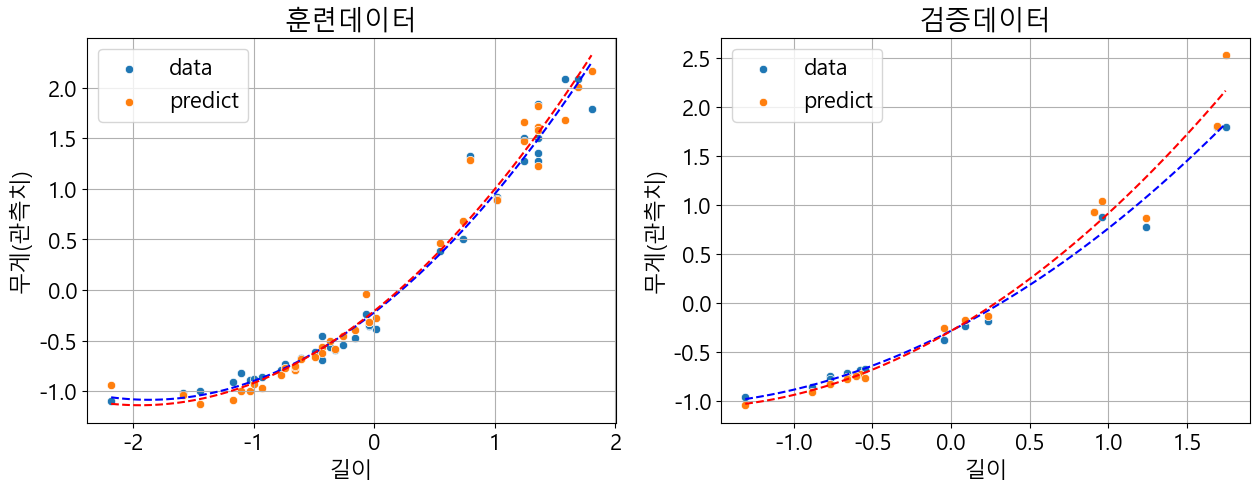

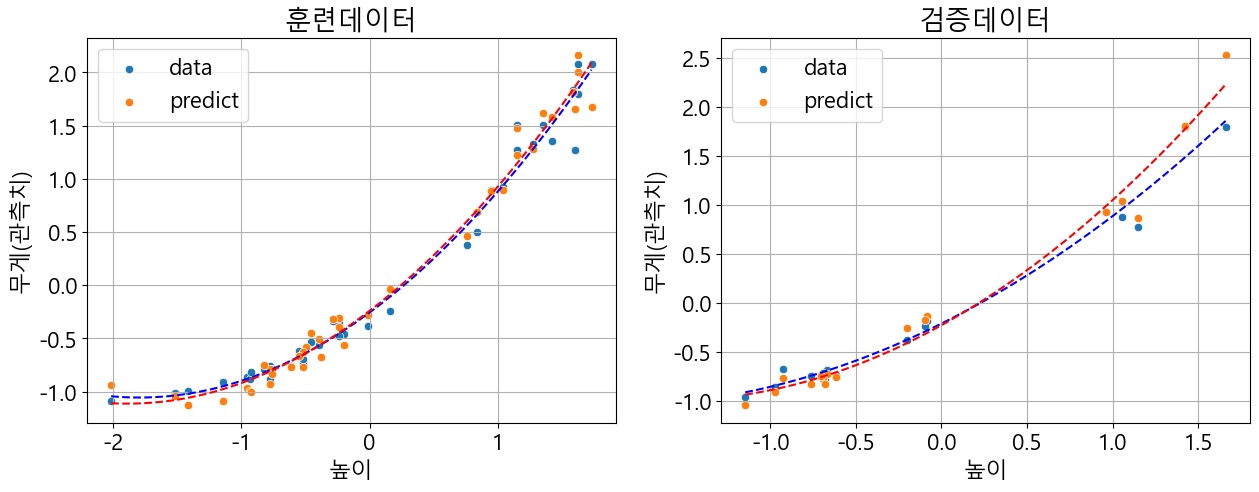

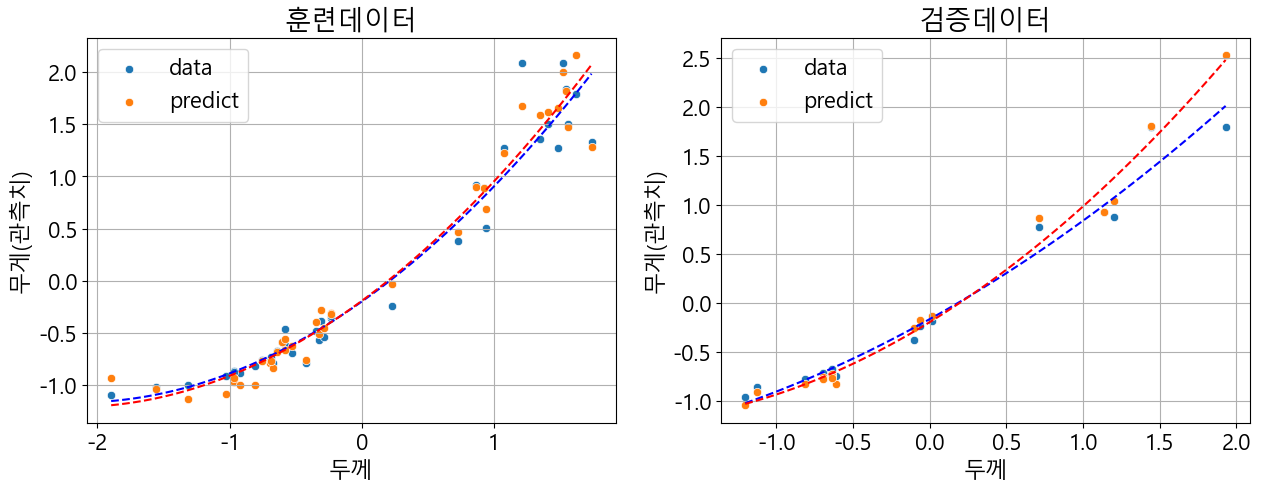

In [20]:
for key in ['길이', '높이', '두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))